In [15]:
import numpy as np
import matplotlib.pyplot as plt
from imripy import constants as c, kepler, merger_system as ms, halo, inspiral, plot_utils as pu, detector
from imripy.inspiral import forces
import plotting
import common

This notebook explores the inclination change in inspirals due to alignment with accretion disks.

First, it explores the alignment procedure with different initial angles (and animates them?). The inspirals take a while to compute, so they are saved for optional later use.
Later, the critical alignment angle is calculated via a binary search.

In [2]:
# Example System
m1 = 1e5 * c.solar_mass_to_pc
m2 = 10. * c.solar_mass_to_pc

hs = ms.HostSystem(m1)

## Environmental Effects

In [3]:
# GW loss
gw = inspiral.forces.GWLoss()
# Stellar Distribution
stellarHalo, stellarDiffusion = common.StellarDistributionAna(hs, E_m_s=m2)
# Accretion Disk
dmDisk, gdf_dm = common.AccretionDisk(hs)
r_stellar = 6.95e8 * c.m_to_pc # solar radius
ggd_dm = inspiral.forces.GasGeometricDrag(r_stellar, disk=dmDisk)
# DM spikes
spike_73, df_73 = common.DMSpike(hs, 7./3.)
spike_32, df_32 = common.DMSpike(hs, 3./2.)

In [4]:
inclined = lambda t, y, *args: np.abs(y[4]) - 1e-3
inclined.terminal = True

## Inspirals with gas dynamical friction

In [5]:
a0 = 1e5 * hs.r_isco
e0 = 0.
i0_s = np.array([1, 5, 10, 15, 18.5, 19.5, 20, 20.5, 21.5, 25, 45, 90, 135, 160, 179]) /180. * np.pi

In [6]:
t_GW = 3.*2**(7./2)/85 * a0**4 * (1.-e0)**(7./2) / m1**2 / m2

k = 0.34
sigma = np.sqrt(m1 / (1.+ stellarHalo.alpha) / a0)
t_AM =  ( 2*k*sigma**3 / (stellarHalo.density(a0)/stellarDiffusion.E_m_s)
          / stellarDiffusion.E_m_s**2 / stellarDiffusion.CoulombLogarithm * (1.-e0))

In [7]:
# Inspirals with SD+GDF, SD+GDF+DM3/2, and SD+GDF+DM7/3
opt_sd_gdf = inspiral.Classic.EvolutionOptions(dissipativeForces=[gw, stellarDiffusion, gdf_dm],
                                              inclinationChange=True, considerRelativeVelocities=True,
                                              progradeRotation=True, verbose=1, accuracy=1e-9,
                                             additionalEvents=[inclined])

opt_sd_gdf_32 = inspiral.Classic.EvolutionOptions(dissipativeForces=[gw, stellarDiffusion, gdf_dm, df_32],
                                              inclinationChange=True, considerRelativeVelocities=True,
                                              progradeRotation=True, verbose=1, accuracy=1e-9,
                                             additionalEvents=[inclined])

opt_sd_gdf_73 = inspiral.Classic.EvolutionOptions(dissipativeForces=[gw, stellarDiffusion, gdf_dm, df_73],
                                              inclinationChange=True, considerRelativeVelocities=True,
                                              progradeRotation=True, verbose=1, accuracy=1e-9,
                                             additionalEvents=[inclined])

In [29]:
evs_sd_gdf = []
evs_sd_gdf_32 = []
evs_sd_gdf_73 = []
for i0 in i0_s:
    k0 = kepler.KeplerOrbit(hs, m2, a0, e0, inclination_angle = i0)
    T_i = np.abs(i0 / gdf_dm.dinclination_angle_dt(hs, k0,opt=opt_sd_gdf))
    print(t_AM, t_GW, T_i)
    ev = inspiral.Classic.Evolve(hs, k0, t_fin=1e2*np.min([t_AM, t_GW, T_i]), opt=opt_sd_gdf)
    evs_sd_gdf.append(ev)
    ev1 = inspiral.Classic.Evolve(hs, k0, t_fin=2.*ev.t[-1], opt=opt_sd_gdf_32)
    evs_sd_gdf_32.append(ev1)
    ev2 = inspiral.Classic.Evolve(hs, k0, t_fin=2.*ev.t[-1], opt=opt_sd_gdf_73)
    evs_sd_gdf_73.append(ev2)

809117.234008031 2.4840112175465093e+18 12.053176365010467
Evolving from  100000.0  to  1.0 r_isco   on circular orbits  with  Options: dissipative forces employed {GWLoss, Stellar Diffusion2*, GasDynamicalFriction, }, accuracy = 1.0e-09, with inclination change
A termination event occurred.
 -> Ended at 9.985e+04r_isco. Evolution took 127.6459s real time
Evolving from  100000.0  to  1.0 r_isco   on circular orbits  with  Options: dissipative forces employed {GWLoss, Stellar Diffusion2*, GasDynamicalFriction, DynamicalFriction, }, accuracy = 1.0e-09, with inclination change
A termination event occurred.
 -> Ended at 9.985e+04r_isco. Evolution took 113.7002s real time
Evolving from  100000.0  to  1.0 r_isco   on circular orbits  with  Options: dissipative forces employed {GWLoss, Stellar Diffusion2*, GasDynamicalFriction, DynamicalFriction, }, accuracy = 1.0e-09, with inclination change
A termination event occurred.
 -> Ended at 9.984e+04r_isco. Evolution took 113.4483s real time
809117

/media/data/Documents/PhD/imripy/src/imripy/inspiral/forces.py:130: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return -(1.-e**2)**(3./2.)/2./np.pi * quad(integrand, 0., 2.*np.pi, limit = 100)[0]


A termination event occurred.
 -> Ended at 1.631e+04r_isco. Evolution took 582.5792s real time
Evolving from  100000.0  to  1.0 r_isco   on circular orbits  with  Options: dissipative forces employed {GWLoss, Stellar Diffusion2*, GasDynamicalFriction, DynamicalFriction, }, accuracy = 1.0e-09, with inclination change
A termination event occurred.
 -> Ended at 1.631e+04r_isco. Evolution took 597.2717s real time
Evolving from  100000.0  to  1.0 r_isco   on circular orbits  with  Options: dissipative forces employed {GWLoss, Stellar Diffusion2*, GasDynamicalFriction, DynamicalFriction, }, accuracy = 1.0e-09, with inclination change
A termination event occurred.
 -> Ended at 1.460e+04r_isco. Evolution took 607.5659s real time
809117.234008031 2.4840112175465093e+18 1286513.3344209534
Evolving from  100000.0  to  1.0 r_isco   on circular orbits  with  Options: dissipative forces employed {GWLoss, Stellar Diffusion2*, GasDynamicalFriction, }, accuracy = 1.0e-09, with inclination change
A term

/media/data/Documents/PhD/imripy/src/imripy/inspiral/forces.py:534: RuntimeWarning: divide by zero encountered in divide
  1./2. * np.log((1. + v_rel_tot/c_s)/(1. - v_rel_tot/c_s)) - v_rel_tot/c_s) # subsonic regime
/media/data/Documents/PhD/imripy/src/imripy/inspiral/forces.py:534: RuntimeWarning: invalid value encountered in double_scalars
  1./2. * np.log((1. + v_rel_tot/c_s)/(1. - v_rel_tot/c_s)) - v_rel_tot/c_s) # subsonic regime
/media/data/Documents/PhD/imripy/src/imripy/halo/baryonic.py:978: RuntimeWarning: invalid value encountered in double_scalars
  interpHalo.density = lambda r, z : density_interp(r)*np.exp(-z**2/scale_height_interp(r)**2)
/media/data/Documents/PhD/imripy/src/imripy/halo/baryonic.py:978: RuntimeWarning: divide by zero encountered in double_scalars
  interpHalo.density = lambda r, z : density_interp(r)*np.exp(-z**2/scale_height_interp(r)**2)
/media/data/Documents/PhD/imripy/src/imripy/kepler.py:215: RuntimeWarning: invalid value encountered in sqrt
  v = np.

A termination event occurred.
 -> Ended at 2.667e+00r_isco. Evolution took 1034.7165s real time
809117.234008031 2.4840112175465093e+18 4245317.877383056
Evolving from  100000.0  to  1.0 r_isco   on circular orbits  with  Options: dissipative forces employed {GWLoss, Stellar Diffusion2*, GasDynamicalFriction, }, accuracy = 1.0e-09, with inclination change
A termination event occurred.
 -> Ended at 2.667e+00r_isco. Evolution took 1164.4624s real time
Evolving from  100000.0  to  1.0 r_isco   on circular orbits  with  Options: dissipative forces employed {GWLoss, Stellar Diffusion2*, GasDynamicalFriction, DynamicalFriction, }, accuracy = 1.0e-09, with inclination change
A termination event occurred.
 -> Ended at 2.667e+00r_isco. Evolution took 1101.2901s real time
Evolving from  100000.0  to  1.0 r_isco   on circular orbits  with  Options: dissipative forces employed {GWLoss, Stellar Diffusion2*, GasDynamicalFriction, DynamicalFriction, }, accuracy = 1.0e-09, with inclination change
A te

/media/data/Documents/PhD/imripy/src/imripy/inspiral/forces.py:130: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return -(1.-e**2)**(3./2.)/2./np.pi * quad(integrand, 0., 2.*np.pi, limit = 100)[0]


A termination event occurred.
 -> Ended at 2.667e+00r_isco. Evolution took 1071.7928s real time
Evolving from  100000.0  to  1.0 r_isco   on circular orbits  with  Options: dissipative forces employed {GWLoss, Stellar Diffusion2*, GasDynamicalFriction, DynamicalFriction, }, accuracy = 1.0e-09, with inclination change
A termination event occurred.
 -> Ended at 2.667e+00r_isco. Evolution took 1071.4395s real time
Evolving from  100000.0  to  1.0 r_isco   on circular orbits  with  Options: dissipative forces employed {GWLoss, Stellar Diffusion2*, GasDynamicalFriction, DynamicalFriction, }, accuracy = 1.0e-09, with inclination change
A termination event occurred.
 -> Ended at 2.667e+00r_isco. Evolution took 984.4202s real time
809117.234008031 2.4840112175465093e+18 543077139.9964972
Evolving from  100000.0  to  1.0 r_isco   on circular orbits  with  Options: dissipative forces employed {GWLoss, Stellar Diffusion2*, GasDynamicalFriction, }, accuracy = 1.0e-09, with inclination change
A ter

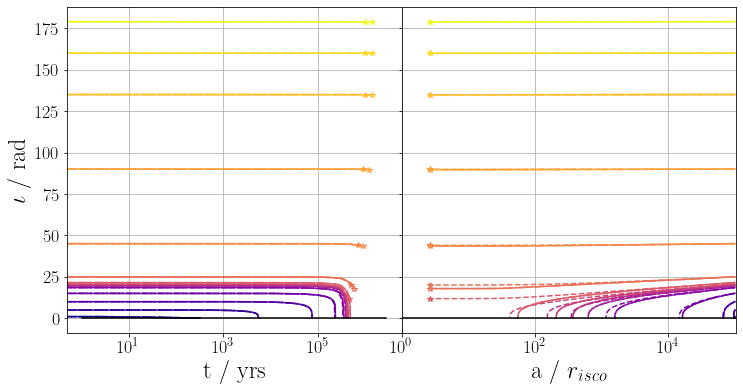

In [16]:
fig, axs = plt.subplots(1,2, figsize=(12,6))
axs[0].set_prop_cycle('color',plt.cm.plasma(np.linspace(0,1, len(evs_sd_gdf))))
for i, (ev, ev1, ev2) in enumerate(zip(evs_sd_gdf,evs_sd_gdf_32, evs_sd_gdf_73)):
    #l=pu.plotEvolution(hs, ev, ax_a=axs[1], label=f"$\iota_0={i0_s[i]/np.pi*180:.0f}$")
    #pu.plotEvolution(hs, ev1, ax_a=axs[1] ,color=l.get_c(), linestyle='-.')
    #pu.plotEvolution(hs, ev2, ax_a=axs[1] ,color=l.get_c(), linestyle='--')
    
    l, = axs[0].plot(ev.t/c.year_to_pc, ev.inclination_angle/np.pi*180)
    axs[0].plot(ev1.t/c.year_to_pc, ev1.inclination_angle/np.pi*180, color=l.get_c(), linestyle='-.')
    axs[0].plot(ev2.t/c.year_to_pc, ev2.inclination_angle/np.pi*180, color=l.get_c(), linestyle='--')
    
    axs[1].plot(ev.a/hs.r_isco, ev.inclination_angle/np.pi*180, color=l.get_c())
    axs[1].plot(ev1.a/hs.r_isco, ev1.inclination_angle/np.pi*180, color=l.get_c(), linestyle='-.')
    axs[1].plot(ev2.a/hs.r_isco, ev2.inclination_angle/np.pi*180, color=l.get_c(), linestyle='--')
    
    if ev.a[-1] < 4.*hs.r_isco:
        axs[0].plot(ev.t[-1]/c.year_to_pc, ev.inclination_angle[-1]/np.pi*180, 
                      marker='*', color=l.get_c(), fillstyle='none')
        axs[1].plot(ev.a[-1]/hs.r_isco, ev.inclination_angle[-1]/np.pi*180, 
                       marker='*', color=l.get_c(), fillstyle='none')
        #axs[0,0].plot(evs_sd_gdf_32[i].t[-1]/c.year_to_pc, evs_sd_gdf_32[i].inclination_angle[-1]/np.pi*180, 
        #                  marker='*', color=l.get_c(), fillstyle='left', markeredgecolor=l.get_c())
    if ev2.a[-1] < 4.*hs.r_isco:
        axs[0].plot(ev2.t[-1]/c.year_to_pc, ev2.inclination_angle[-1]/np.pi*180, 
                          marker='*', color=l.get_c(), fillstyle='full', markeredgecolor=l.get_c())
        axs[1].plot(ev2.a[-1]/hs.r_isco, ev2.inclination_angle[-1]/np.pi*180, 
                          marker='*', color=l.get_c(), fillstyle='full', markeredgecolor=l.get_c())


axs[0].set_xscale('log'); #axs[0].set_yscale('log'); 
axs[0].plot(axs[0].get_xlim(), [0.,0.], color='black')
axs[0].set_xlabel("t / yrs"); axs[0].set_ylabel("$\iota$ / deg°")
#axs[1].legend(); axs[1].set_xlabel("t / yrs"); axs[1].set_ylabel("a / $r_{isco}$")
axs[1].set_xlim(left=1.); axs[1].set_xscale('log')
axs[1].set_xlabel("a / $r_{isco}$"); axs[0].set_ylabel("$\iota$ / rad")
axs[1].plot(axs[1].get_xlim(), [0.,0.], color='black')

for ax in axs.flatten():
    ax.grid()
fig.subplots_adjust(wspace=0.)
axs[1].get_yaxis().set_ticklabels([]);

#fig.savefig(f"plots/inc_sd_gdf_{m1/c.solar_mass_to_pc:.0e}.pdf", bbox_inches="tight")

In [34]:
# Save for later use
for i, ev in enumerate(evs_sd_gdf):
    ev.save(f"runs/iota_sd_1e5_1e1_{i}.npz")
for i, ev in enumerate(evs_sd_gdf_32):
    ev.save(f"runs/iota_sd_32_1e5_1e1_{i}.npz")
for i, ev in enumerate(evs_sd_gdf_73):
    ev.save(f"runs/iota_sd_73_1e5_1e1_{i}.npz")

In [12]:
# and load
evs_sd_gdf = []
evs_sd_gdf_32 = []
evs_sd_gdf_73 = []
for i in range(15):
    evs_sd_gdf.append(inspiral.Classic.EvolutionResults.load(f"runs/iota_sd_1e5_1e1_{i}.npz", hs, opt_sd_gdf))
for i in range(15):
    evs_sd_gdf_32.append(inspiral.Classic.EvolutionResults.load(f"runs/iota_sd_32_1e5_1e1_{i}.npz", hs, opt_sd_gdf_32))
for i in range(15):
    evs_sd_gdf_73.append(inspiral.Classic.EvolutionResults.load(f"runs/iota_sd_73_1e5_1e1_{i}.npz", hs, opt_sd_gdf_32))

#### Animate

## Inspirals with Geometric Drag

In [ ]:
a0 = 1e5 * hs.r_isco
e0 = 0.
i0_s = np.array([1, 5, 10, 15, 20, 25, 45, 90, 135, 160, 179]) /180. * np.pi

In [ ]:
inclined = lambda t, y, *args: np.abs(y[4]) - 1e-3
inclined.terminal = True

In [ ]:
opt_sd_ggd = inspiral.Classic.EvolutionOptions(dissipativeForces={gw, stellarDiffusion, ggd_dm},
                                              inclinationChange=True, considerRelativeVelocities=True,
                                              progradeRotation=True, verbose=1, accuracy=1e-9,
                                             additionalEvents=[inclined])

opt_sd_ggd_32 = inspiral.Classic.EvolutionOptions(dissipativeForces={gw, stellarDiffusion, ggd_dm, df_32},
                                              inclinationChange=True, considerRelativeVelocities=True,
                                              progradeRotation=True, verbose=1, accuracy=1e-9,
                                             additionalEvents=[inclined])

opt_sd_ggd_73 = inspiral.Classic.EvolutionOptions(dissipativeForces={gw, stellarDiffusion, ggd_dm, df_73},
                                              inclinationChange=True, considerRelativeVelocities=True,
                                              progradeRotation=True, verbose=1, accuracy=1e-9,
                                             additionalEvents=[inclined])

In [ ]:
t_GW = 3.*2**(7./2)/85 * a0**4 * (1.-e0)**(7./2) / m1**2 / m2

k = 0.34
sigma = np.sqrt(m1 / (1.+ stellarHalo.alpha) / a0)
t_AM =  ( 2*k*sigma**3 / (stellarHalo.density(a0)/stellarDiffusion.E_m_s)
          / stellarDiffusion.E_m_s2 / stellarDiffusion.CoulombLogarithm * (1.-e0))

In [ ]:
evs_sd_ggd = []
evs_sd_ggd_32 = []
evs_sd_ggd_73 = []
for i,i0 in enumerate(i0_s):
    k0 = kepler.KeplerOrbit(hs, m2, a0, e0, inclination_angle = i0)
    T_i = np.abs(i0 / ggd_dm.dinclination_angle_dt(hs, k0,opt=opt_sd_ggd))
    print(i, t_AM, t_GW, T_i)
    ev = inspiral.Classic.Evolve(hs, k0, t_fin=1e2*np.min([t_AM, t_GW, T_i]), opt=opt_sd_ggd)
    evs_sd_ggd.append(ev)
    ev1 = inspiral.Classic.Evolve(hs, k0, t_fin=2.*ev.t[-1], opt=opt_sd_ggd_32)
    evs_sd_ggd_32.append(ev1)
    ev2 = inspiral.Classic.Evolve(hs, k0, t_fin=2.*ev.t[-1], opt=opt_sd_ggd_73)
    evs_sd_ggd_73.append(ev2)

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(12,6))
for i, (ev, ev1, ev2) in enumerate(zip(evs_sd_ggd, evs_sd_ggd_32, evs_sd_ggd_73)):
    #l=pu.plotEvolution(hs, ev, ax_a=axs[1], label=f"$\iota_0={i0_s[i]/np.pi*180:.0f}$")
    #pu.plotEvolution(hs, ev1, ax_a=axs[1] ,color=l.get_c(), linestyle='-.')
    #pu.plotEvolution(hs, ev2, ax_a=axs[1] ,color=l.get_c(), linestyle='--')
    
    l, = axs[0].plot(ev.t/c.year_to_pc, ev.inclination_angle/np.pi*180)
    axs[0].plot(ev1.t/c.year_to_pc, ev1.inclination_angle/np.pi*180, color=l.get_c(), linestyle='-.')
    axs[0].plot(ev2.t/c.year_to_pc, ev2.inclination_angle/np.pi*180, color=l.get_c(), linestyle='--')
    
    axs[1].plot(ev.a/hs.r_isco, ev.inclination_angle/np.pi*180, color=l.get_c())
    axs[1].plot(ev1.a/hs.r_isco, ev1.inclination_angle/np.pi*180, color=l.get_c(), linestyle='-.')
    axs[1].plot(ev2.a/hs.r_isco, ev2.inclination_angle/np.pi*180, color=l.get_c(), linestyle='--')
    
    if ev.a[-1] < 2.*hs.r_isco:
        axs[0].plot(ev.t[-1]/c.year_to_pc, ev.inclination_angle[-1]/np.pi*180, 
                      marker='*', color=l.get_c(), fillstyle='none')
        axs[1].plot(ev.a[-1]/hs.r_isco, ev.inclination_angle[-1]/np.pi*180, 
                       marker='*', color=l.get_c(), fillstyle='none')
        #axs[0,0].plot(evs_sd_gdf_32[i].t[-1]/c.year_to_pc, evs_sd_gdf_32[i].inclination_angle[-1]/np.pi*180, 
        #                  marker='*', color=l.get_c(), fillstyle='left', markeredgecolor=l.get_c())
    if ev2.a[-1] < 2.*hs.r_isco:
        axs[0].plot(ev2.t[-1]/c.year_to_pc, ev2.inclination_angle[-1]/np.pi*180, 
                          marker='*', color=l.get_c(), fillstyle='full', markeredgecolor=l.get_c())
        axs[1].plot(ev2.a[-1]/hs.r_isco, ev2.inclination_angle[-1]/np.pi*180, 
                          marker='*', color=l.get_c(), fillstyle='full', markeredgecolor=l.get_c())


axs[0].set_xscale('log'); #axs[0].set_yscale('log'); 
axs[0].plot(axs[0].get_xlim(), [0.,0.], color='black')
axs[0].set_xlabel("t / yrs"); axs[0].set_ylabel("$\iota$ / deg°")
#axs[1].legend(); axs[1].set_xlabel("t / yrs"); axs[1].set_ylabel("a / $r_{isco}$")
axs[1].set_xlim(left=1.); axs[1].set_xscale('log')
axs[1].set_xlabel("a / $r_{isco}$"); #axs[1].set_ylabel("$\iota$ / rad")
axs[1].plot(axs[1].get_xlim(), [0.,0.], color='black')

for ax in axs.flatten():
    ax.grid()
fig.subplots_adjust(wspace=0.)
axs[1].get_yaxis().set_ticklabels([]);

fig.savefig(f"plots/inc_sd_ggd_{m1/c.solar_mass_to_pc:.0e}.pdf", bbox_inches="tight")

## Critical Alignment Angle

In [5]:
inclined = lambda t, y, *args: np.abs(y[4]) - 1e-3
inclined.terminal = True

In [6]:
def find_alignment_angle(hs, k0, gdf, opt, i0_left=1./180.*np.pi, i0_right=180./180.*np.pi, depth=0, max_depth=8, evs=[]):
    """
    Binary search for the critical alignment angle
    """
    i0 = (i0_left + i0_right)/2.
    if depth >= max_depth or (i0_right - i0_left) < 0.1/180.*np.pi:
        return i0, evs
    if len(opt.additionalEvents) < 1:
        opt.additionalEvents.append(inclined)
    
    k0.inclination_angle = i0
    # timescales
    t_GW = 3.*2**(7./2)/85 * k0.a**4 * (1.-k0.e)**(7./2) / hs.m1**2 / k0.m2
    stellarDiffusion = opt.dissipativeForces[1]; stellarHalo = stellarDiffusion.stellarDistribution
    k = 0.34; sigma = np.sqrt(hs.m1 / (1.+ stellarHalo.alpha) / k0.a)
    t_AM =  ( 2*k*sigma**3 / (stellarHalo.density(k0.a)/stellarDiffusion.E_m_s)
          / stellarDiffusion.E_m_s**2 / stellarDiffusion.CoulombLogarithm * (1.-k0.e))
    T_i = np.abs(i0 / gdf.dinclination_angle_dt(hs, k0, opt=opt))
    time_estimates = np.array([t_AM, t_GW, T_i])
    if len(evs) > 0 and (i0_right-i0_left) < 10./180.*np.pi:
        time_estimates = np.append(time_estimates, evs[-1].t[-1])
    # lets go
    print(depth, i0, time_estimates)
    ev = inspiral.Classic.Evolve(hs, k0, t_fin=1e1*np.min(time_estimates), opt=opt)
    evs.append(ev)
    if ev.a[-1] < 3.*hs.r_isco:
        return find_alignment_angle(hs, k0, gdf, opt, i0_left=i0_left, i0_right=i0, 
                                        depth=depth+1, max_depth=max_depth, evs=evs)
    else:
        return find_alignment_angle(hs, k0, gdf, opt, i0_left=i0, i0_right=i0_right, 
                                        depth=depth+1, max_depth=max_depth, evs=evs)

In [9]:
def compare(m1, m2):
    """
    Calculates the critical alignment angle with and without spikes
    """
    hs = ms.HostSystem(m1)
    
    #environmental effects
    gw = inspiral.forces.GWLoss()
    stellarHalo, stellarDiffusion = common.StellarDistributionAna(hs, E_m_s=m2)
    dmDisk, gdf_dm = common.AccretionDisk(hs)
    spike_73, df_73 = common.DMSpike(hs, 7./3.)
    spike_32, df_32 = common.DMSpike(hs, 3./2.)
    
    # different inspirals
    opt_base = inspiral.Classic.EvolutionOptions(dissipativeForces=[gw, stellarDiffusion, gdf_dm],
                                                 inclinationChange=True, considerRelativeVelocities=True, 
                                                 accuracy=1e-9, additionalEvents=[inclined])
    
    opt_32 = inspiral.Classic.EvolutionOptions(dissipativeForces=[gw, stellarDiffusion, gdf_dm , df_32],
                                                 inclinationChange=True, considerRelativeVelocities=True, 
                                                 accuracy=1e-9, additionalEvents=[inclined])

    opt_73 = inspiral.Classic.EvolutionOptions(dissipativeForces=[gw, stellarDiffusion, gdf_dm , df_73],
                                                 inclinationChange=True, considerRelativeVelocities=True, 
                                                 accuracy=1e-9, additionalEvents=[inclined])
    # initial orbit
    a0 = 1e5 * hs.r_isco
    e0 = 0.
    k0 = kepler.KeplerOrbit(hs, m2, a0, e0)
    # alignemnt angles
    i0_base, evs_base = find_alignment_angle(hs, k0, gdf_dm, opt_base, 
                                             i0_left=15./180.*np.pi, i0_right=30./180.*np.pi, max_depth=10, evs=[])
    i0_32, evs_32 = find_alignment_angle(hs, k0, gdf_dm, opt_32, 
                                             i0_left=15./180.*np.pi, i0_right=30./180.*np.pi, max_depth=10, evs=[])
    i0_73, evs_73 = find_alignment_angle(hs, k0, gdf_dm, opt_73, 
                                             i0_left=15./180.*np.pi, i0_right=30./180.*np.pi, max_depth=10, evs=[])
    
    return [i0_base, i0_32, i0_73], evs_base, evs_32, evs_73

In [10]:
i0s1e5, evs0_1e5, evs1_1e5, evs2_1e5 = compare(1e5*c.solar_mass_to_pc, 10.*c.solar_mass_to_pc)

0 0.39269908169872414 [8.09117234e+05 2.48401122e+18 2.79781118e+06]
Evolving from  100000.0  to  1.0 r_isco   on circular orbits  with  Options: dissipative forces employed {GWLoss, Stellar Diffusion2*, GasDynamicalFriction, }, accuracy = 1.0e-09, with inclination change


/media/data/Documents/PhD/imripy/src/imripy/inspiral/forces.py:534: RuntimeWarning: divide by zero encountered in divide
  1./2. * np.log((1. + v_rel_tot/c_s)/(1. - v_rel_tot/c_s)) - v_rel_tot/c_s) # subsonic regime
/media/data/Documents/PhD/imripy/src/imripy/inspiral/forces.py:534: RuntimeWarning: invalid value encountered in double_scalars
  1./2. * np.log((1. + v_rel_tot/c_s)/(1. - v_rel_tot/c_s)) - v_rel_tot/c_s) # subsonic regime
/media/data/Documents/PhD/imripy/src/imripy/halo/baryonic.py:978: RuntimeWarning: invalid value encountered in double_scalars
  interpHalo.density = lambda r, z : density_interp(r)*np.exp(-z**2/scale_height_interp(r)**2)
/media/data/Documents/PhD/imripy/src/imripy/halo/baryonic.py:978: RuntimeWarning: divide by zero encountered in double_scalars
  interpHalo.density = lambda r, z : density_interp(r)*np.exp(-z**2/scale_height_interp(r)**2)
/media/data/Documents/PhD/imripy/src/imripy/kepler.py:215: RuntimeWarning: invalid value encountered in sqrt
  v = np.

A termination event occurred.
 -> Ended at 2.667e+00r_isco. Evolution took 1264.0708s real time
1 0.32724923474893675 [8.09117234e+05 2.48401122e+18 1.35701499e+06 1.60441290e+05]
Evolving from  100000.0  to  1.0 r_isco   on circular orbits  with  Options: dissipative forces employed {GWLoss, Stellar Diffusion2*, GasDynamicalFriction, }, accuracy = 1.0e-09, with inclination change


/media/data/Documents/PhD/imripy/src/imripy/inspiral/forces.py:533: RuntimeWarning: invalid value encountered in log
  1./2. * np.log(1. - (c_s/v_rel_tot)**2) + ln_Lambda, # supersonic regime
/media/data/Documents/PhD/imripy/src/imripy/inspiral/forces.py:130: IntegrationWarning: The maximum number of subdivisions (100) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return -(1.-e**2)**(3./2.)/2./np.pi * quad(integrand, 0., 2.*np.pi, limit = 100)[0]


A termination event occurred.
 -> Ended at 1.273e+03r_isco. Evolution took 1159.7733s real time
2 0.35997415822383044 [8.09117234e+05 2.48401122e+18 1.98140481e+06 1.10296483e+05]
Evolving from  100000.0  to  1.0 r_isco   on circular orbits  with  Options: dissipative forces employed {GWLoss, Stellar Diffusion2*, GasDynamicalFriction, }, accuracy = 1.0e-09, with inclination change
A termination event occurred.
 -> Ended at 1.793e+02r_isco. Evolution took 1260.5696s real time
3 0.3763366199612773 [8.09117234e+05 2.48401122e+18 2.36349650e+06 1.35074574e+05]
Evolving from  100000.0  to  1.0 r_isco   on circular orbits  with  Options: dissipative forces employed {GWLoss, Stellar Diffusion2*, GasDynamicalFriction, }, accuracy = 1.0e-09, with inclination change
A termination event occurred.
 -> Ended at 5.036e+01r_isco. Evolution took 1387.3704s real time
4 0.38451785083000073 [8.09117234e+05 2.48401122e+18 2.57385377e+06 1.48651507e+05]
Evolving from  100000.0  to  1.0 r_isco   on circular

/media/data/Documents/PhD/imripy/src/imripy/halo/dm.py:147: RuntimeWarning: invalid value encountered in double_scalars
  return np.where(r > self.r_min, self.rho_spike * (self.r_spike/r)**self.alpha, 0.)
/media/data/Documents/PhD/imripy/src/imripy/inspiral/forces.py:455: RuntimeWarning: invalid value encountered in sqrt
  v_esc = np.sqrt(2*halo.potential(r))
/media/data/Documents/PhD/imripy/src/imripy/inspiral/forces.py:452: RuntimeWarning: divide by zero encountered in divide
  alpha =  4.*np.pi*simpson(v2_list * f_list, x=np.sqrt(v2_list)) / density # TODO: Change Normalization of f from density to 1?
/media/data/Documents/PhD/imripy/src/imripy/inspiral/forces.py:461: RuntimeWarning: divide by zero encountered in divide
  beta =  4.*np.pi*simpson(v_list**2 * f_list * np.log((v_list + v_rel)/(v_list-v_rel)), x=v_list) / density
/media/data/Documents/PhD/imripy/src/imripy/inspiral/forces.py:463: RuntimeWarning: divide by zero encountered in divide
  delta =  -8.*np.pi*v_rel*simpson(v_

A termination event occurred.
 -> Ended at 2.667e+00r_isco. Evolution took 1117.4347s real time
1 0.32724923474893675 [8.09117234e+05 2.48401122e+18 1.35701499e+06 1.60426720e+05]
Evolving from  100000.0  to  1.0 r_isco   on circular orbits  with  Options: dissipative forces employed {GWLoss, Stellar Diffusion2*, GasDynamicalFriction, DynamicalFriction, }, accuracy = 1.0e-09, with inclination change
A termination event occurred.
 -> Ended at 1.273e+03r_isco. Evolution took 1261.1251s real time
2 0.35997415822383044 [8.09117234e+05 2.48401122e+18 1.98140481e+06 1.10287106e+05]
Evolving from  100000.0  to  1.0 r_isco   on circular orbits  with  Options: dissipative forces employed {GWLoss, Stellar Diffusion2*, GasDynamicalFriction, DynamicalFriction, }, accuracy = 1.0e-09, with inclination change
A termination event occurred.
 -> Ended at 1.793e+02r_isco. Evolution took 1301.1201s real time
3 0.3763366199612773 [8.09117234e+05 2.48401122e+18 2.36349650e+06 1.35063070e+05]
Evolving from  

In [11]:
i0s1e4, evs0_1e4, evs1_1e4, evs2_1e4 = compare(1e4*c.solar_mass_to_pc, 10.*c.solar_mass_to_pc)

0 0.39269908169872414 [3.75184673e+04 2.48401122e+16 4.35227504e+05]
Evolving from  100000.0  to  1.0 r_isco   on circular orbits  with  Options: dissipative forces employed {GWLoss, Stellar Diffusion2*, GasDynamicalFriction, }, accuracy = 1.0e-09, with inclination change
A termination event occurred.
 -> Ended at 2.667e+00r_isco. Evolution took 699.0729s real time
1 0.32724923474893675 [3.75184673e+04 2.48401122e+16 2.11095385e+05 1.88262488e+04]
Evolving from  100000.0  to  1.0 r_isco   on circular orbits  with  Options: dissipative forces employed {GWLoss, Stellar Diffusion2*, GasDynamicalFriction, }, accuracy = 1.0e-09, with inclination change
A termination event occurred.
 -> Ended at 3.259e+02r_isco. Evolution took 888.1841s real time
2 0.35997415822383044 [3.75184673e+04 2.48401122e+16 3.08226157e+05 1.44336654e+04]
Evolving from  100000.0  to  1.0 r_isco   on circular orbits  with  Options: dissipative forces employed {GWLoss, Stellar Diffusion2*, GasDynamicalFriction, }, accur

A termination event occurred.
 -> Ended at 1.909e+02r_isco. Evolution took 848.9558s real time
6 0.30066023442558565 [3.75184673e+04 2.48401122e+16 1.50705771e+05 1.04878019e+04]
Evolving from  100000.0  to  1.0 r_isco   on circular orbits  with  Options: dissipative forces employed {GWLoss, Stellar Diffusion2*, GasDynamicalFriction, DynamicalFriction, }, accuracy = 1.0e-09, with inclination change
A termination event occurred.
 -> Ended at 9.878e+01r_isco. Evolution took 824.6597s real time
7 0.3016828882841761 [3.75184673e+04 2.48401122e+16 1.52755598e+05 1.06662252e+04]
Evolving from  100000.0  to  1.0 r_isco   on circular orbits  with  Options: dissipative forces employed {GWLoss, Stellar Diffusion2*, GasDynamicalFriction, DynamicalFriction, }, accuracy = 1.0e-09, with inclination change
A termination event occurred.
 -> Ended at 5.820e+01r_isco. Evolution took 832.6743s real time


In [12]:
i0s1e6, evs0_1e6, evs1_1e6, evs2_1e6 = compare(1e6*c.solar_mass_to_pc, 10.*c.solar_mass_to_pc)

0 0.39269908169872414 [1.89064555e+07 2.48401122e+20 1.91964967e+07]
Evolving from  100000.0  to  1.0 r_isco   on circular orbits  with  Options: dissipative forces employed {GWLoss, Stellar Diffusion2*, GasDynamicalFriction, }, accuracy = 1.0e-09, with inclination change
A termination event occurred.
 -> Ended at 2.667e+00r_isco. Evolution took 834.9972s real time
1 0.32724923474893675 [1.89064555e+07 2.48401122e+20 9.31097374e+06 1.11799673e+06]
Evolving from  100000.0  to  1.0 r_isco   on circular orbits  with  Options: dissipative forces employed {GWLoss, Stellar Diffusion2*, GasDynamicalFriction, }, accuracy = 1.0e-09, with inclination change
A termination event occurred.
 -> Ended at 9.799e+02r_isco. Evolution took 895.5975s real time
2 0.35997415822383044 [1.89064555e+07 2.48401122e+20 1.35950170e+07 8.00849205e+05]
Evolving from  100000.0  to  1.0 r_isco   on circular orbits  with  Options: dissipative forces employed {GWLoss, Stellar Diffusion2*, GasDynamicalFriction, }, accur

A termination event occurred.
 -> Ended at 2.667e+00r_isco. Evolution took 866.9407s real time
6 0.3783819276784582 [1.89064555e+07 2.48401122e+20 1.65688856e+07 1.04348655e+06]
Evolving from  100000.0  to  1.0 r_isco   on circular orbits  with  Options: dissipative forces employed {GWLoss, Stellar Diffusion2*, GasDynamicalFriction, DynamicalFriction, }, accuracy = 1.0e-09, with inclination change
A termination event occurred.
 -> Ended at 2.667e+00r_isco. Evolution took 884.8647s real time
7 0.3773592738198678 [1.89064555e+07 2.48401122e+20 1.63920418e+07 1.03551571e+06]
Evolving from  100000.0  to  1.0 r_isco   on circular orbits  with  Options: dissipative forces employed {GWLoss, Stellar Diffusion2*, GasDynamicalFriction, DynamicalFriction, }, accuracy = 1.0e-09, with inclination change
A termination event occurred.
 -> Ended at 2.667e+00r_isco. Evolution took 1049.0018s real time


In [17]:
np.array(i0s1e4)*180/np.pi, np.array(i0s1e5)*180/np.pi, np.array(i0s1e6)*180/np.pi

NameError: name 'i0s1e4' is not defined

In [16]:
# optional save for later
for i, ev in enumerate(evs2_1e4):
    ev.save(f"runs/caa_evs2_1e4_1e1_{i}.npz")

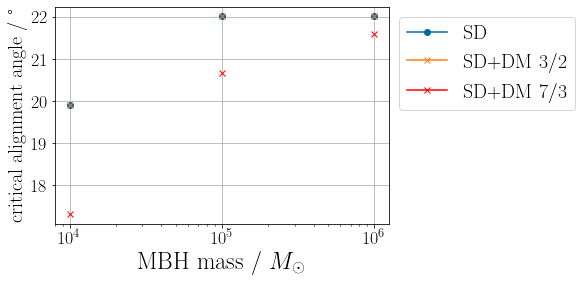

In [30]:
labels=["SD", "SD+DM $3/2$", "SD+DM $7/3$"]
for i in range(len(i0s1e5)):
    l, = plt.plot(1e5, i0s1e5[i]*180./np.pi, marker='o' if not i >= 1 else 'x', label=labels[i], color='red' if i ==2 else None)
    plt.plot(1e6, i0s1e6[i]*180./np.pi, marker='o' if not i >= 1 else 'x', color=l.get_c())
    plt.plot(1e4, i0s1e4[i]*180./np.pi, marker='o' if not i >= 1 else 'x', color=l.get_c())


plt.xscale('log')
plt.xlabel("MBH mass / $M_\odot$")
plt.ylabel("critical alignment angle / °", fontsize=20)
plt.grid(); plt.legend(bbox_to_anchor=(1,1))
#plt.savefig("plots/caa.pdf", bbox_inches="tight")